# OOD Detection for Customer Intent Classification

## TODO

- Try `DataDepthScorer`

## Resources

Articles
- Contrastive Out-of-Distribution Detection for Pretrained Transformers
- Beyond Mahalanobis-Based Scores for Textual OOD Detection

Datasets 
- [banking77](https://huggingface.co/datasets/banking77)
- [ATIS Airline Travel Information System](https://www.kaggle.com/datasets/hassanamin/atis-airlinetravelinformationsystem) 
- [Bitext - Customer Service Tagged Training Dataset for Intent Detection](https://github.com/bitext/customer-support-intent-detection-training-dataset)

Model
- [philschmid/BERT-Banking77](https://huggingface.co/philschmid/BERT-Banking77) 

BERT resources
- [BERT Neural Network - EXPLAINED!](https://www.youtube.com/watch?v=xI0HHN5XKDo) 
- [Transformer Neural Networks - EXPLAINED! (Attention is all you need)](https://www.youtube.com/watch?v=TQQlZhbC5ps)

Github
- [`Todd`](https://github.com/icannos/Todd)
- [OOD Classification `ToddBenchmark`](https://github.com/icannos/ToddBenchmark/tree/master/examples/classifications) 

## Setup

### Import

In [1]:
%load_ext autoreload
%autoreload 2

In [69]:
import pandas as pd 
import numpy as np 

from tqdm import tqdm
from typing import List, Dict

from rich import print

from itertools import chain

import matplotlib.pyplot as plt 
import seaborn as sns

import pickle as pkl 
import json

In [86]:
from sklearn.metrics import (
    roc_curve, 
    precision_recall_curve, 
    auc
) 

In [3]:
from transformers import AutoConfig

import torch 
from torch import Tensor

In [4]:
from Todd import (
    ScorerType, 
    MahalanobisScorer, 
    CosineProjectionScorer, 
    DataDepthScorer, 
)

In [5]:
from toddbenchmark.classification_datasets import (
    prep_model, 
    load_b77, 
)
from toddbenchmark.classification_datasets_configs import (
    DATASETS_CONFIGS,
    load_requested_dataset,
)

from toddbenchmark.utils_classification import (
    prepare_detectors,
    evaluate_dataloader,
)

### Load config, model and tokenizer

In [6]:
MODELS = {"BERT": "philschmid/BERT-Banking77", "DistilBERT": "philschmid/DistilBERT-Banking77"} 

In [7]:
config = AutoConfig.from_pretrained(MODELS["BERT"]) 
config

BertConfig {
  "_name_or_path": "philschmid/BERT-Banking77",
  "_num_labels": 77,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Refund_not_showing_up",
    "1": "activate_my_card",
    "2": "age_limit",
    "3": "apple_pay_or_google_pay",
    "4": "atm_support",
    "5": "automatic_top_up",
    "6": "balance_not_updated_after_bank_transfer",
    "7": "balance_not_updated_after_cheque_or_cash_deposit",
    "8": "beneficiary_not_allowed",
    "9": "cancel_transfer",
    "10": "card_about_to_expire",
    "11": "card_acceptance",
    "12": "card_arrival",
    "13": "card_delivery_estimate",
    "14": "card_linking",
    "15": "card_not_working",
    "16": "card_payment_fee_charged",
    "17": "card_payment_not_recognised",
    "18": "card_payment_wrong_exchange_rate",
   

In [68]:
LABEL_MAPPING = config.id2label

# convert label mapping to json dict & save

label_mapping_json = {
    "id": list(LABEL_MAPPING.keys()), 
    "label": list(LABEL_MAPPING.values())
}

file_path = "./datasets/b77_label_mapping.json"
with open(file_path, "w") as f:
    json.dump(label_mapping_json, f)

In [9]:
model, tokenizer = prep_model(MODELS["BERT"], config={"label": config._num_labels})

In [10]:
model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [11]:
N_HIDDEN_LAYERS = 13

## Datasets

Inspired by this [article](https://arxiv.org/abs/2104.08812), an instance $(\mathrm{x}, y)$ to be OOD if $y \notin \mathcal{Y}_{\text{train}}$. In this context, all instances in the training and test sets derived from `banking77` are labelled `OOD=0`. In the opposite, the instances in `ATIS` and `Bitext` are labelled `OOD=1`.

Then, different OOD scoring functions $f(\mathrm{x}): \mathcal{X} \to \mathbb{R}$ are applied to all the instances. The functions are supposed to return a low (high) score for an instance such that $y\in\mathcal{Y}_{\text{train}}$ ($y\notin\mathcal{Y}_{\text{train}}$).

### Load IN-DS dataset

In [47]:
config_args_in = {
    "tokenizer": tokenizer, 
    "train_size": 3000, 
    "validation_size": 0, 
    "test_size": 3000, 
    "ood_label": 0
}

In [48]:
train_loader_b77, _, test_loader_b77 = load_requested_dataset(config_name="b77", **config_args_in)

Found cached dataset banking77 (C:/Users/pemma/.cache/huggingface/datasets/banking77/default/1.1.0/ff44c4421d7e70aa810b0fa79d36908a38b87aff8125d002cd44f7fcd31f493c)
100%|██████████| 2/2 [00:00<00:00, 142.88it/s]
Loading cached processed dataset at C:\Users\pemma\.cache\huggingface\datasets\banking77\default\1.1.0\ff44c4421d7e70aa810b0fa79d36908a38b87aff8125d002cd44f7fcd31f493c\cache-789d791b63800d76.arrow
Loading cached processed dataset at C:\Users\pemma\.cache\huggingface\datasets\banking77\default\1.1.0\ff44c4421d7e70aa810b0fa79d36908a38b87aff8125d002cd44f7fcd31f493c\cache-f2f24408eb806cc9.arrow


In [14]:
for batch in train_loader_b77: 
    break 

batch

{'text': ['I am still waiting on my card?',
  "What can I do if my card still hasn't arrived after 2 weeks?",
  'I have been waiting over a week. Is the card still coming?',
  'Can I track my card while it is in the process of delivery?',
  'How do I know if I will get my card, or if it is lost?',
  'When did you send me my new card?',
  'Do you have info about the card on delivery?',
  'What do I do if I still have not received my new card?',
  'Does the package with my card have tracking?',
  "I ordered my card but it still isn't here",
  'Why has my new card still not come?',
  "I still haven't received my card after two weeks, is it lost?",
  'Can you track my card for me?',
  'Is there a way to track the delivery of my card?',
  "It's been a week since I ordered my card and it's not here. Please help?",
  'Will I be able to track the card that was sent to me?'],
 'labels': tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]),
 'ood': tensor([0, 0, 0, 0, 0, 0, 0

In [15]:
assert sum(batch["labels"].shape[0] for batch in train_loader_b77) == config_args_in["train_size"]
assert sum(batch["labels"].shape[0] for batch in test_loader_b77) == config_args_in["test_size"]

### Load OUT-DS dataset

In [88]:
config_args_out = {
    "tokenizer": tokenizer, 
    "train_size": 0, 
    "validation_size": 0, 
    "test_size": 3000, 
    "ood_label": 1
}

In [16]:
_, _, test_loader_atis = load_requested_dataset(config_name="atis", **config_args_out)
_, _, test_loader_bitext = load_requested_dataset(config_name="bitext", **config_args_out)

In [17]:
for batch in test_loader_atis: 
    break

batch

{'text': ['i want to fly from boston at 838 am and arrive in denver at 1110 in the morning',
  'what flights are available from pittsburgh to baltimore on thursday morning',
  'what is the arrival time in san francisco for the 755 am flight leaving washington',
  'cheapest airfare from tacoma to orlando',
  'round trip fares from pittsburgh to philadelphia under 1000 dollars',
  'i need a flight tomorrow from columbus to minneapolis',
  'what kind of aircraft is used on a flight from cleveland to dallas',
  'show me the flights from pittsburgh to los angeles on thursday',
  'all flights from boston to washington',
  'what kind of ground transportation is available in denver',
  'show me the flights from dallas to san francisco',
  'show me the flights from san diego to newark by way of houston',
  "what's the airport at orlando",
  'what is the cheapest flight from boston to bwi',
  'all flights to baltimore after 6 pm',
  'show me the first class fares from boston to denver'],
 'label

In [18]:
for batch in test_loader_bitext: 
    break

batch

{'text': ['how can I cancel purchase 113542617735902?',
  'can you help me canceling purchase 00004587345?',
  'i want assistance to cancel purchase 732201349959',
  'i want assistance to cancel order 732201349959',
  "I don't want my last item, help me cancel order 370795561790",
  'I can no longer pay for purchase 00004587345',
  'I need assistance cancelling purchase 732201349959',
  'is it possible to cancel order 113542617735902?',
  'assistance cancelling purchase 00123842',
  'i can no longer pay for purchase 113542617735902',
  'how tocancel purchase 00004587345',
  'i need assistance cancelling order 00123842',
  'problems with cancelling purchase 00123842',
  'need to cancel order 00004587345',
  'I have got to cancel purchase 732201349959',
  "I can't afford this order, cancel purchase 732201349959"],
 'labels': ['cancel_order',
  'cancel_order',
  'cancel_order',
  'cancel_order',
  'cancel_order',
  'cancel_order',
  'cancel_order',
  'cancel_order',
  'cancel_order',
  'c

In [20]:
for batch in train_loader_b77: 
    break 

In [21]:
batch

{'text': ['I am still waiting on my card?',
  "What can I do if my card still hasn't arrived after 2 weeks?",
  'I have been waiting over a week. Is the card still coming?',
  'Can I track my card while it is in the process of delivery?',
  'How do I know if I will get my card, or if it is lost?',
  'When did you send me my new card?',
  'Do you have info about the card on delivery?',
  'What do I do if I still have not received my new card?',
  'Does the package with my card have tracking?',
  "I ordered my card but it still isn't here",
  'Why has my new card still not come?',
  "I still haven't received my card after two weeks, is it lost?",
  'Can you track my card for me?',
  'Is there a way to track the delivery of my card?',
  "It's been a week since I ordered my card and it's not here. Please help?",
  'Will I be able to track the card that was sent to me?'],
 'labels': tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]),
 'ood': tensor([0, 0, 0, 0, 0, 0, 0

## Detectors

### Mathematical formulation

#### Logits-based

**Maximum-Softmax probability**

$$
s_{\text{MSP}}(\mathrm{x}) = 1 - \max_{y \in \mathcal{Y}} p_{Y\mid X}(y \mid \mathrm{x})
$$

where $p_{Y\mid X}(y \mid \mathrm{x})$ is the soft-probability predicted by the classifier after $\mathrm{x}$ has been observed.

**Energy**

$$
s_{E}(\mathrm{x}) = - T \times \log \bigg[\sum_{y \in \mathcal{Y}} \exp \Big(\frac{g_y(\mathrm{x})}{T} \Big) \bigg]
$$

where $g_y(\mathrm{x})$ represents the logit corresponding to the class label $y$ and $T$ is the temperature parameter.

#### Hidden-states based

**Mahalanibis distance**

Given a probability distribution $P$ on $\mathbb{R}^d$ with mean vector $\mathrm{\mu}$  and positive-definite covariance matrix $S$, the Mahalanobis distance of a point $\mathrm{x} \in \mathbb{R}^d$ from $P$ is: 
$$
d_M(\mathrm{x}, P) = \sqrt{(\mathrm{x} - \mathrm{\mu})^T S^{-1} (\mathrm{x} - \mathrm{\mu})}
$$

Since $S$ is positive-definite, so is $S^{-1}$, thus the square roots are always defined (strong hypothesis).

**Cosine projection**

Cosine similarity between $\mathrm{x}_1$ and $\mathrm{x}_2$ is defined as: 

$$
\text{cos}(\mathrm{x}_1, \mathrm{x}_2) = \frac{\mathrm{x}_1 \cdot \mathrm{x}_2}{\max (||\mathrm{x}_1||_2 \cdot ||\mathrm{x}_2||_2, \epsilon)}
$$

The scorer function derived from cosine similarity is defined as follows: 

$$
s_C = - \max_{\mathrm{x}_i \in S_{n, \hat{y}}^{\text{train}}} \text{cos}(\mathrm{x}, \mathrm{x}_i)
$$

where $(\mathrm{x}, \hat{y})$ is an unseen sample and $S_{n, \hat{y}}^{\text{train}}$ is the set of reference embeddings with $\hat{y}$ as predicted class. 

### Fit

In [49]:
layer_selection = {"last": [-1], "all": [l for l in range(N_HIDDEN_LAYERS)]}

detectors: List[ScorerType] = [
    MahalanobisScorer(layers=layer_selection["last"]), 
    CosineProjectionScorer(layers=layer_selection["all"]), 
    # DataDepthScorer(layers=layer_selection["all"])
]

detector_names = [detector.__class__.__name__ for detector in detectors]

In [50]:
for detector in detectors: 
    print(detector.__class__.__name__, detector.__dict__) 

MahalanobisScorer
{
    'score_names': [],
    'chosen_state': 'encoder_hidden_states',
    'use_first_token_only': True,
    'accumulated_embeddings': defaultdict(<class 'list'>, {}),
    'layers': {-1},
    'accumulation_device': 'cpu',
    'covs': None,
    'means': None
}

CosineProjectionScorer
{
    'score_names': [],
    'chosen_state': 'encoder_hidden_states',
    'use_first_token_only': True,
    'accumulated_embeddings': defaultdict(<class 'list'>, {}),
    'layers': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},
    'accumulation_device': 'cpu',
    'reference_embeddings': {}
}

In [51]:
detectors = prepare_detectors(detectors, model, train_loader_b77, tokenizer)

Fitting detectors...: 100%|██████████| 2/2 [00:25<00:00, 12.86s/it]


In [52]:
file_path = "./backup/detectors_v0.pkl"

with open(file_path, "wb") as f: 
    pkl.dump(detectors, f)

del detectors

### Evaluate

In [53]:
file_path = "./backup/detectors_v0.pkl"

with open(file_path, "rb") as f: 
    detectors = pkl.load(f)

In [54]:
detectors

[MahalanobisScorer, CosineProjectionScorer]

#### IN

In [22]:
print("Evaluating on the in-distribution training set")

records_in_train = evaluate_dataloader(
    model,
    train_loader_b77,
    tokenizer,
    detectors
)

Evaluating on the in-distribution training set

Evaluating detectors...: 100%|██████████| 188/188 [12:25<00:00,  3.96s/it]


In [23]:
file_name = "./backup/records_in_train.pkl"

with open(file_name, "wb") as file: 
    pkl.dump(records_in_train, file)

del records_in_train

In [70]:
print("Evaluating on the in-distribution test set")

records_in_test = evaluate_dataloader(
    model,
    test_loader_b77,
    tokenizer,
    detectors
)

Evaluating on the in-distribution test set

Evaluating detectors...: 100%|██████████| 188/188 [20:27<00:00,  6.53s/it]


In [74]:
file_name = "./backup/records_in_test.pkl"

with open(file_name, "wb") as file: 
    pkl.dump(records_in_test, file)

del records_in_test

#### OUT

In [26]:
print("Evaluating on the out-of-distribution ATIS dataset")

records_out_atis = evaluate_dataloader(
    model,
    test_loader_atis,
    tokenizer,
    detectors
)

Evaluating on the out-of-distribution ATIS dataset

Evaluating detectors...: 100%|██████████| 188/188 [10:42<00:00,  3.42s/it]


In [27]:
file_name = "./backup/records_out_atis.pkl"

with open(file_name, "wb") as file: 
    pkl.dump(records_out_atis, file)

del records_out_atis

In [28]:
print("Evaluating on the out-of-distribution BITEXT dataset")

records_out_bitext = evaluate_dataloader(
    model,
    test_loader_bitext,
    tokenizer,
    detectors
)

Evaluating on the out-of-distribution BITEXT dataset

Evaluating detectors...: 100%|██████████| 188/188 [09:59<00:00,  3.19s/it]


In [29]:
file_name = "./backup/records_out_bitext.pkl"

with open(file_name, "wb") as file: 
    pkl.dump(records_out_bitext, file)

del records_out_bitext

## Results

### Load records

In [75]:
def load_records(record_type: str) -> Dict:
    file_name = f"./backup/records_{record_type}.pkl"
    with open(file_name, "rb") as file: 
        records = pkl.load(file)

    return records

records = {
    record_type: load_records(record_type)
    for record_type in (
        "in_train", 
        "in_test", 
        "out_atis", 
        "out_bitext"
    )
}

In [76]:
SCORERS = ("CosineProjectionScorer", "MahalanobisScorer", "DataDepthScorer")

def average_scorer_per_layer(records: Dict, scorer_name: str) -> np.ndarray:

    if scorer_name not in SCORERS:
        raise ValueError(f"scorer_name must be in {SCORERS}")

    values_per_layer = [
        values 
        for key, values in records.items()
        if scorer_name in key
    ]

    return np.mean(values_per_layer, axis=0)

In [77]:
maha_key = list(records["in_train"].keys())[0]

for record_type, records_ in records.items(): 
    # average CosineProjectionScorer over all hidden layers
    records[record_type]["CosineProjectionScorerAvg"] = average_scorer_per_layer(records_, "CosineProjectionScorer")

    # simplify MahalanobisScorer key name 
    records[record_type]["MahalanobisScorerLast"] = records[record_type][maha_key]

### Scorer distribution

#### All datasets

In [78]:
scorer_names = [
    "MahalanobisScorerLast", 
    "CosineProjectionScorerAvg", 
    "msp", 
    "energy"
]

all_scores = {
    scorer: {
        record_type: records[record_type][scorer]
        for record_type in records.keys()
    }
    for scorer in scorer_names
}

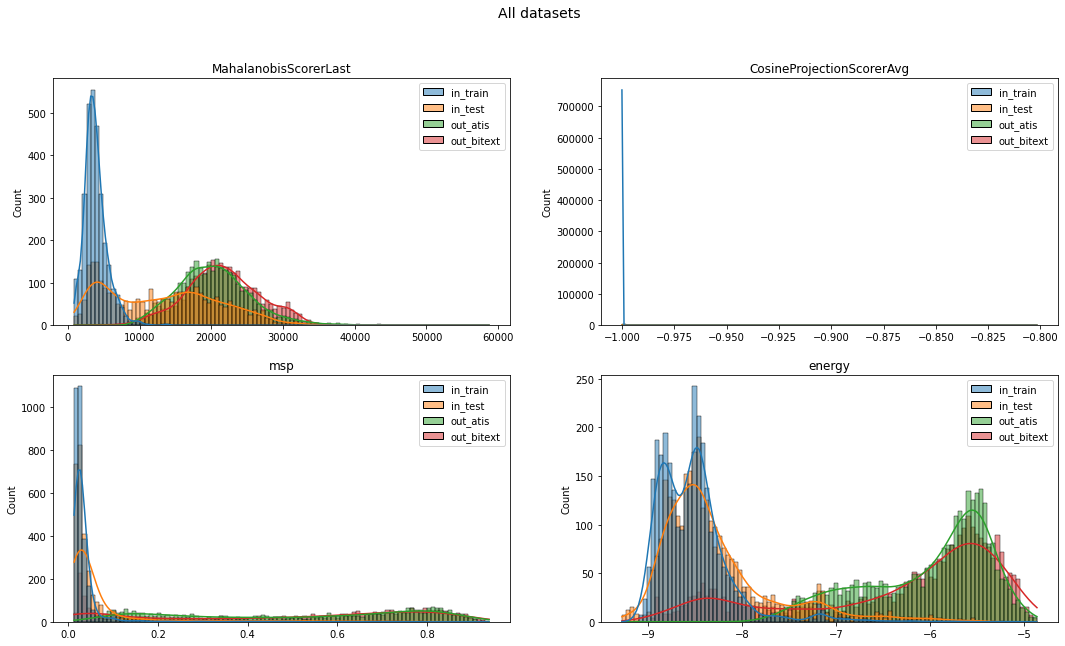

In [84]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 10))
fig.suptitle("All datasets", size=14)

for (scorer, values), ax in zip(all_scores.items(), axes.flatten()):
    tmp = pd.DataFrame(values)
    sns.histplot(data=tmp, ax=ax, bins=100, kde=True) 

    ax.set_title(scorer); 

#### `banking77`

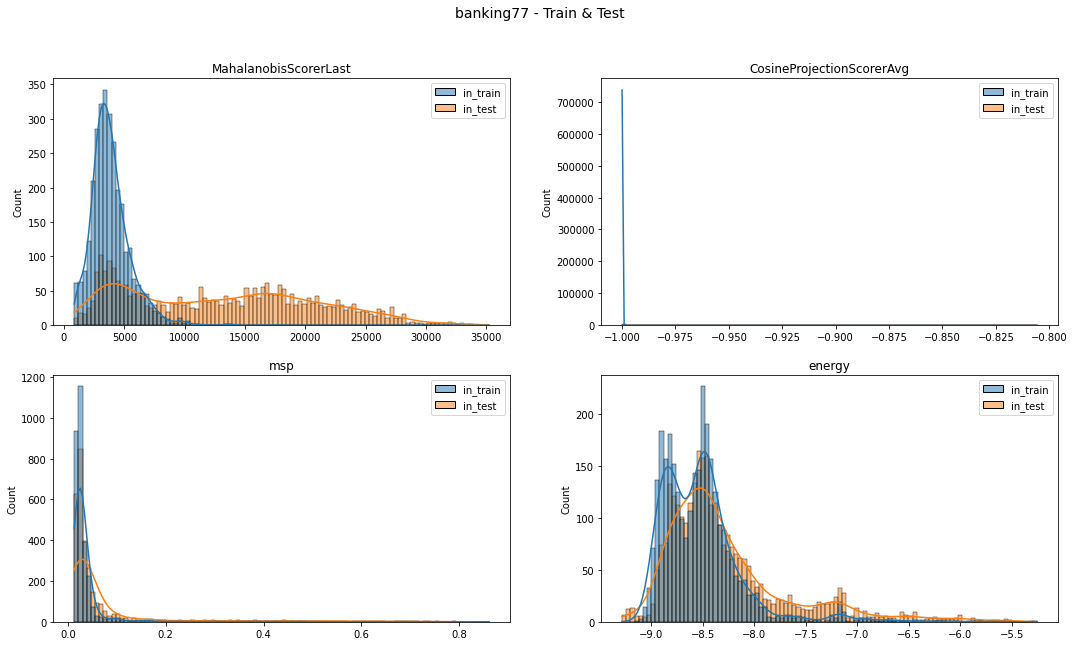

In [83]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 10))
fig.suptitle("banking77 - Train & Test", size=14)

for (scorer, values), ax in zip(all_scores.items(), axes.flatten()):
    tmp = pd.DataFrame(values)[["in_train", "in_test"]]
    sns.histplot(data=tmp, ax=ax, bins=100, kde=True) 

    ax.set_title(scorer); 

#### `banking77` & `ATIS`

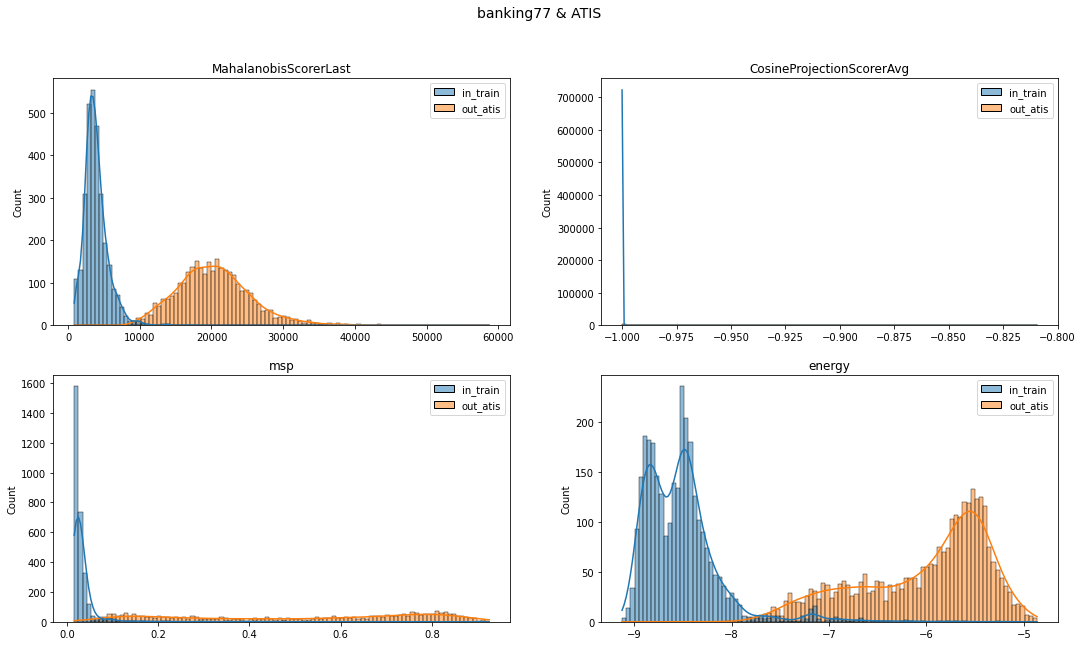

In [82]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 10))
fig.suptitle("banking77 & ATIS", size=14)

for (scorer, values), ax in zip(all_scores.items(), axes.flatten()):
    tmp = pd.DataFrame(values)[["in_train", "out_atis"]]
    sns.histplot(data=tmp, ax=ax, bins=100, kde=True) 

    ax.set_title(scorer); 

#### `banking77` & `Bitext`

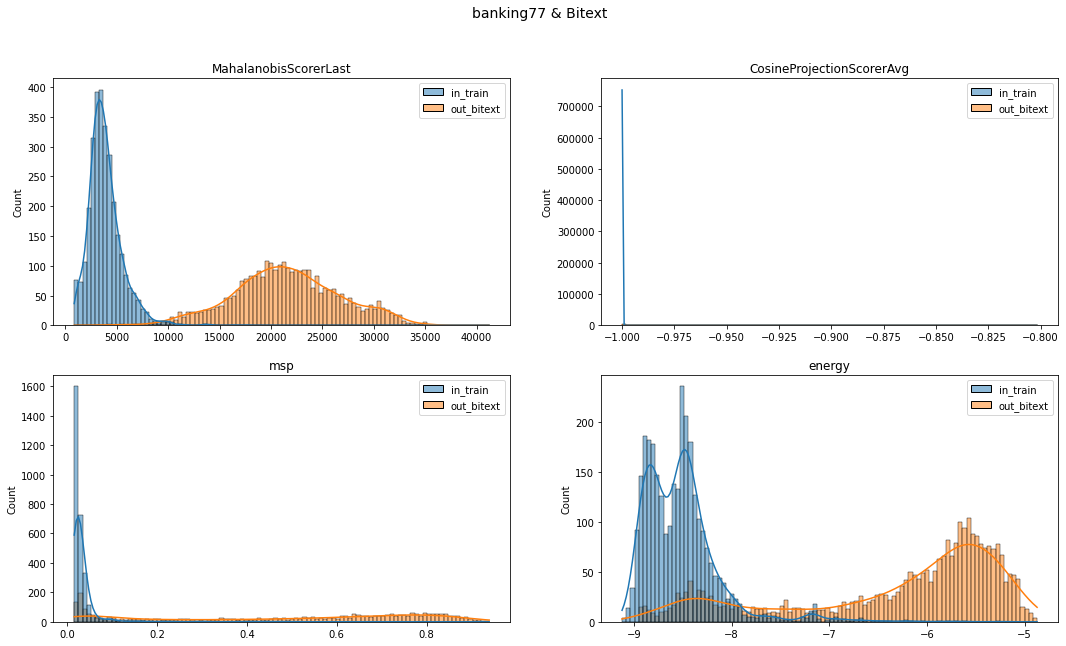

In [85]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 10))
fig.suptitle("banking77 & Bitext", size=14)

for (scorer, values), ax in zip(all_scores.items(), axes.flatten()):
    tmp = pd.DataFrame(values)[["in_train", "out_bitext"]]
    sns.histplot(data=tmp, ax=ax, bins=100, kde=True) 

    ax.set_title(scorer); 

### Metrics

In [89]:
# get OOD labels 
    # 0 for IN-DS samples
    # 1 for OUT-DS samples

ood_labels_in = [
    config_args_in["ood_label"] 
    for _ in range(config_args_in["train_size"]+config_args_in["test_size"])
]

ood_labels_out = [
    config_args_out["ood_label"] 
    for _ in range(config_args_out["test_size"])
]

# IN-DS (b77) labels + OUT-DS labels (atis) + OUT-DS labels (bitext)
ood_labels = ood_labels_in + ood_labels_out + ood_labels_out

# get OOD scores for each scoring function
ood_scores = {
    scorer: list(chain(*[
        ds for ds in all_scores[scorer].values()
    ]))
    for scorer in scorer_names
}

# compute (fpr, tpr) for different thresolds
roc = {
    scorer: roc_curve(ood_labels, ood_scores[scorer], pos_label=1)
    for scorer in scorer_names
}

# compute (precision, recall) for different thresolds
prc = {
    scorer: precision_recall_curve(ood_labels, ood_scores[scorer], pos_label=1)
    for scorer in scorer_names
}

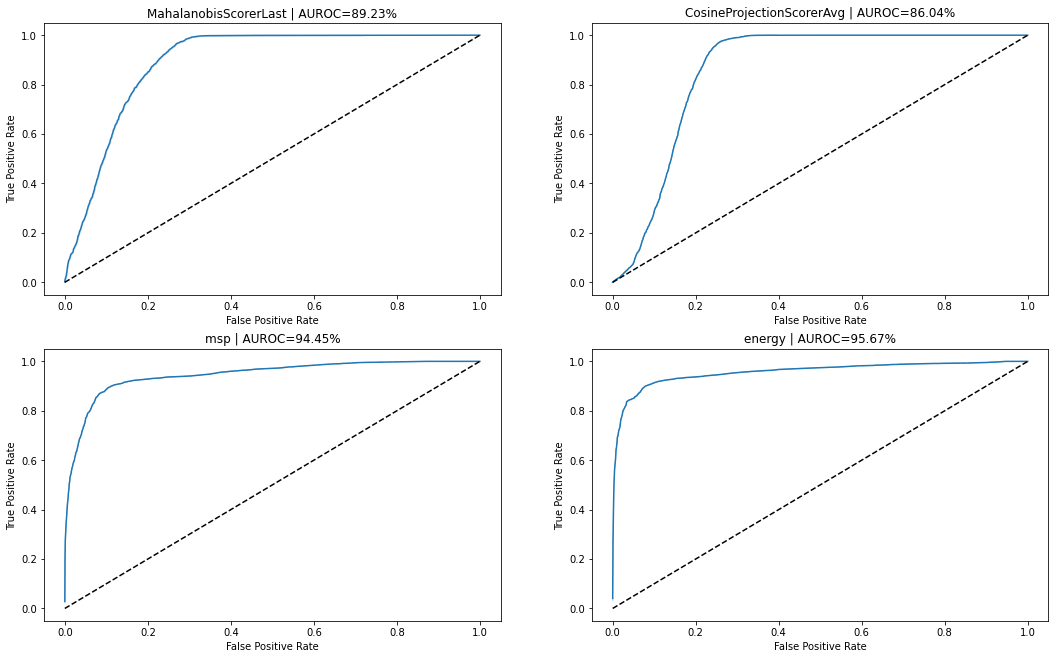

In [90]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 11))

for (scorer, (fpr, tpr, _)), ax in zip(roc.items(), axes.flatten()): 
    sns.lineplot(x=fpr, y=tpr, ax=ax)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", ax=ax, color="black") 

    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")

    auroc = auc(fpr, tpr)
    ax.set_title(f"{scorer} | AUROC={round(100*auroc, 2)}%"); 

**Note**: precision & recall

$$
\begin{aligned}
\text{Pr}  & = \mathbb{P}(Z=1 \mid s(\mathrm{x}) \leq \gamma) \\
\text{Re} & = \mathbb{P}(s(\mathrm{x}) \leq \gamma \mid Z=1)
\end{aligned}
$$

where $s(.)$ is the scoring function and $\gamma$ the thresold. 

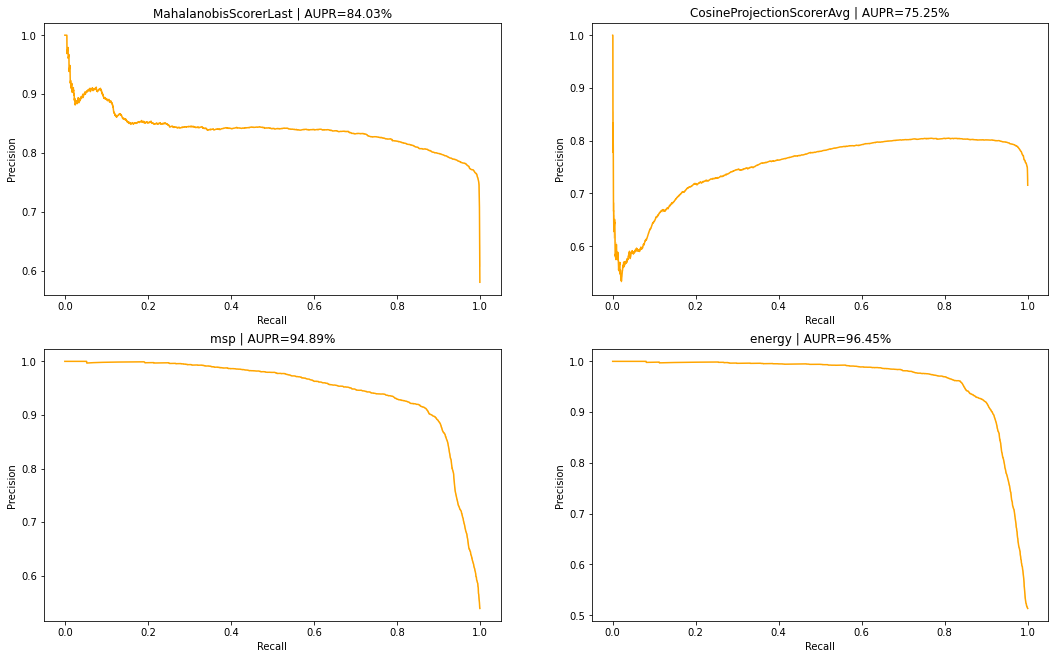

In [91]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 11))

for (scorer, (precision, recall, _)), ax in zip(prc.items(), axes.flatten()): 
    sns.lineplot(x=recall, y=precision, ax=ax, color="orange")

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")

    aupr = auc(recall, precision)
    ax.set_title(f"{scorer} | AUPR={round(100*aupr, 2)}%"); 